Epoch 1/100, Loss: 1.5701, Validation Loss: 1.5881, Accuracy: 0.2381
Epoch 2/100, Loss: 1.2716, Validation Loss: 1.5615, Accuracy: 0.2381
Epoch 3/100, Loss: 1.1146, Validation Loss: 1.5339, Accuracy: 0.2381
Epoch 4/100, Loss: 0.9673, Validation Loss: 1.4984, Accuracy: 0.3333
Epoch 5/100, Loss: 0.8393, Validation Loss: 1.4505, Accuracy: 0.3333
Epoch 6/100, Loss: 0.7845, Validation Loss: 1.3866, Accuracy: 0.5714
Epoch 7/100, Loss: 0.6778, Validation Loss: 1.3023, Accuracy: 0.7619
Epoch 8/100, Loss: 0.6240, Validation Loss: 1.2016, Accuracy: 0.7619
Epoch 9/100, Loss: 0.5872, Validation Loss: 1.0920, Accuracy: 0.7619
Epoch 10/100, Loss: 0.5237, Validation Loss: 0.9774, Accuracy: 0.8095
Epoch 11/100, Loss: 0.4769, Validation Loss: 0.8594, Accuracy: 1.0000
Epoch 12/100, Loss: 0.4303, Validation Loss: 0.7423, Accuracy: 1.0000
Epoch 13/100, Loss: 0.4098, Validation Loss: 0.6327, Accuracy: 1.0000
Epoch 14/100, Loss: 0.3153, Validation Loss: 0.5318, Accuracy: 1.0000
Epoch 15/100, Loss: 0.3139, V

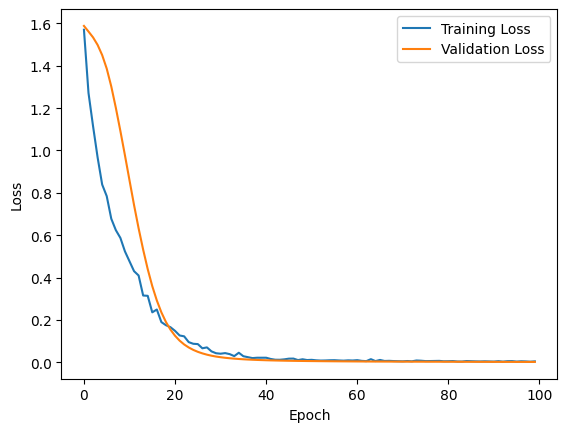

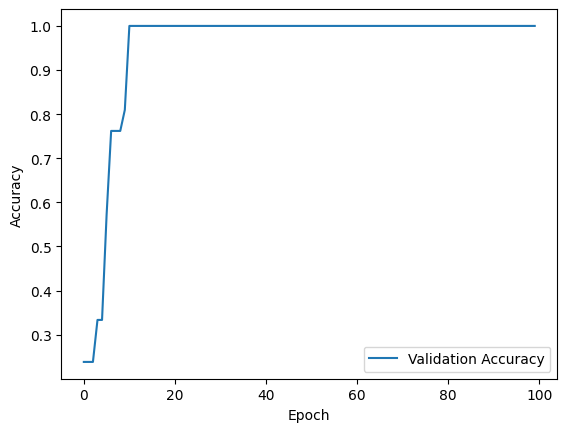

Test Accuracy: 1.0000


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Update window_size to match the number of data rows in your CSV files.
window_size = 65

def load_pressure_data(folder_path, window_size=window_size):
    """
    Load pressure sensor time-series data from 1 EMG and 6 pressure sensors, segment into fixed windows,
    and assign labels.

    Args:
        folder_path: Path to the folder containing CSV files.
        window_size: Number of data points per segment.
    Returns:
        X: Feature matrix (samples x channels x window_size).
        y: Labels corresponding to each sample.
    """
    files = os.listdir(folder_path)
    X, y = [], []

    # Update label mapping based on your pressure sensor categories
    label_mapping = {
        'stable': 0,
        'forward': 1,
        'right': 2,
        'left': 3,
        'back': 4
    }

    for file in files:
        filepath = os.path.join(folder_path, file)
        if not file.endswith('.csv'):
            continue

        # Extract the gesture label from the file name (e.g., "stable" from "stable_rep1_275497649594.csv")
        gesture = file.split('_')[0]
        label = label_mapping.get(gesture)
        if label is None:
            continue

        data = pd.read_csv(filepath)
        emg = data['emg'].values
        fl1 = data['front_left_sensor_1'].values
        fl2 = data['front_left_sensor_2'].values
        fr1 = data['front_right_sensor_1'].values
        fr2 = data['front_right_sensor_2'].values
        bl = data['back_left_sensor'].values
        br = data['back_right_sensor'].values
        # Stack the sensor values to get shape (num_samples, 7)
        sensor_values = np.stack((emg, fl1, fl2, fr1, fr2, bl, br), axis=1)

        # Only segment files that have at least window_size rows.
        if len(sensor_values) < window_size:
            continue

        # Segment data into fixed-size windows.
        # Since each CSV is exactly window_size rows, this loop will run once per file.
        for i in range(0, len(sensor_values) - window_size + 1, window_size):
            segment = sensor_values[i:i + window_size]  # shape (window_size, 3)
            segment = segment.T  # Transpose to shape (channels, window_size)
            X.append(segment)
            y.append(label)

    return np.array(X), np.array(y)

# Update the folder path to where your CSV files are stored.
X, y = load_pressure_data('EMG_and_pressure_data', window_size=window_size)

if X.size == 0 or y.size == 0:
    raise ValueError("No data was loaded. Check your folder path or CSV file formats.")

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_validation_tensor = torch.FloatTensor(X_validation)
X_test_tensor = torch.FloatTensor(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_validation_tensor = torch.LongTensor(y_validation)
y_test_tensor = torch.LongTensor(y_test)

class CNN(nn.Module):
    def __init__(self, num_classes, window_size):
        super(CNN, self).__init__()
        # Updated input channels from 4 to 3 for pressure sensor data.
        self.conv1 = nn.Conv1d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(128)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, kernel_size=2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.pool(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

# Instantiate CNN model with 5 output classes: stable, forward, right, left, back
num_classes = 5
model_cnn = CNN(num_classes=num_classes, window_size=window_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_cnn.parameters(), lr=0.001)

# Early stopping configuration
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

n_epochs = 100
train_losses = []
validation_losses = []
accuracies = []

for epoch in range(n_epochs):
    model_cnn.train()
    optimizer.zero_grad()
    outputs = model_cnn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    model_cnn.eval()
    with torch.no_grad():
        val_outputs = model_cnn(X_validation_tensor)
        val_loss = criterion(val_outputs, y_validation_tensor)
        validation_losses.append(val_loss.item())

        _, predictions = torch.max(val_outputs, 1)
        accuracy = (predictions == y_validation_tensor).float().mean().item()
        accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. Training stopped.")
        break

# Plot training and validation losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
model_cnn.eval()
with torch.no_grad():
    test_outputs = model_cnn(X_test_tensor)
    _, test_predictions = torch.max(test_outputs, 1)
    test_predictions = test_predictions.cpu().numpy()
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
model_save_path = "model.pth"
torch.save(model_cnn.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Load the model
model_cnn_loaded = CNN(num_classes=num_classes, window_size=window_size)
model_cnn_loaded.load_state_dict(torch.load(model_save_path))
model_cnn_loaded.eval()
print("Model loaded successfully")

Model saved to model.pth
Model loaded successfully
